In [1]:
import pandas as pd
import os
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
## The first column of the data file will be read as Phi_1, 2nd- Phi, 3rd phi_2, 4th - x, 5th - y, 6and 7th as CI (confidance index)
path =  r"C:/Users/shett/Downloads/Final Year Porject (FYP)/data/input/HR_complete.csv"  #D:\Python Codes\Recrystallization FYP\HR.xlsx
#print(path)
df = pd.read_csv(path)
#print(df)
df = df.to_numpy()    ##We use numpy arrays since they are easier to manipulate
for i in range(0,len(df[:,3])):
    if df[i+1,3] - df[i,3] != 0:
        stepsize_x = df[1,3] - df[0,3]
        break
for i in range(0,len(df[:,4])):
    if df[i+1,4] - df[i,4] != 0:
        stepsize_y = df[1,3] - df[0,3]
        break

df[:,3] = (df[:, 3] / (stepsize_x)).astype(int)
df[:,4] = (df[:, 4] / (stepsize_y)).astype(int)

r,c = int(np.max(df[:,3])),int(np.max(df[:,4])) ##Dimensions of the datafile for furthur use

print(type(df[:,3]))
print(len(df[:,3]))
print(stepsize_y)
print(stepsize_y)

<class 'numpy.ndarray'>
9409
2.0
2.0


Converting the numpy array 

In [3]:
theta_m = 15 # 15 degree is the critical value for misorientation

s = np.zeros((r+1,c+1,4))  ## np.zeros makes a nested list (which can be thought of a a matrix of r+1 x c+1 storing 3 values). 
                           ## We are going to store the angles in this such that if i call S[x][y][0] we'll get phi_1 for x,y co-ordinates
                           ## simlarly S[x][y][1] = phi for x,y and S[x][y][2] = phi_2 for x,y

for i in df:
    # print(i)
    s[int(i[3])][int(i[4])][0] = i[0]
    s[int(i[3])][int(i[4])][1] = i[1]
    s[int(i[3])][int(i[4])][2] = i[2]
    s[int(i[3])][int(i[4])][3] = i[5]
    

G = np.zeros((r + 1, c + 1, 2, 3, 3)) ## Like above in a r+1 x c+1 matrix now we are storing g and g^-1. We do this after caculating g and g^-1

IQ = np.zeros((r+1,c+1,1))  ## Image quality

max = 0
min = np.inf

for i in df:
    IQ[int(i[3])][int(i[4])][0] = i[5]
    if i[5] > max : max = i[5]
    if i[5] < min : min = i[5]

for i in df:
    IQ[int(i[3])][int(i[4])][0] = 100*(i[5] - min)/(max-min)

Defining the function G

In [4]:
def g(phi1,phi,phi2):                                          ## Gets the g value for a given phi_1,phi,phi_2
    g_one = np.array([ [np.cos(phi1), np.sin(phi1), 0] ,[-np.sin(phi1), np.cos(phi1), 0] ,[0,0,1]])
    g_two = np.array([ [np.cos(phi2), np.sin(phi2), 0] ,[-np.sin(phi2), np.cos(phi2), 0] ,[0,0,1]])
    g = np.array([ [1,0,0], [0, np.cos(phi), np.sin(phi)] ,[0, -np.sin(phi), np.cos(phi)]])

    b = np.matmul(g,g_one)
    c = np.matmul(g_two,b)

    return c

def theta(del_g): ## Takes del_g (a 3x3 numpy array) and gives back the minimum theta 
    symmetry_matrix = np.array([
    [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    [[0, 0, 1], [1, 0, 0], [0, 1, 0]],
    [[0, 1, 0], [0, 0, 1], [1, 0, 0]],
    [[0, -1, 0], [0, 0, 1], [-1, 0, 0]],
    [[0, -1, 0], [0, 0, -1], [1, 0, 0]],
    [[0, 1, 0], [0, 0, -1], [-1, 0, 0]],
    [[0, 0, -1], [1, 0, 0], [0, -1, 0]],
    [[0, 0, -1], [-1, 0, 0], [0, 1, 0]],
    [[0, 0, 1], [-1, 0, 0], [0, -1, 0]],
    [[-1, 0, 0], [0, 1, 0], [0, 0, -1]],
    [[-1, 0, 0], [0, -1, 0], [0, 0, 1]],
    [[1, 0, 0], [0, -1, 0], [0, 0, -1]],
    [[0, 0, -1], [0, -1, 0], [-1, 0, 0]],
    [[0, 0, 1], [0, -1, 0], [1, 0, 0]],
    [[0, 0, 1], [0, 1, 0], [-1, 0, 0]],
    [[0, 0, -1], [0, 1, 0], [1, 0, 0]],
    [[-1, 0, 0], [0, 0, -1], [0, -1, 0]],
    [[1, 0, 0], [0, 0, -1], [0, 1, 0]],
    [[1, 0, 0], [0, 0, 1], [0, -1, 0]],
    [[-1, 0, 0], [0, 0, 1], [0, 1, 0]],
    [[0, -1, 0], [-1, 0, 0], [0, 0, -1]],
    [[0, 1, 0], [-1, 0, 0], [0, 0, 1]],
    [[0, 1, 0], [1, 0, 0], [0, 0, -1]],
    [[0, -1, 0], [1, 0, 0], [0, 0, 1]]])
    
    min_value = np.inf

    for i in symmetry_matrix:
        n_val = (np.arccos((np.trace(np.matmul( i, del_g) ) - 1) / 2))
        #print(n_val)
        if  n_val < min_value:
            min_value = n_val
     
    return min_value

def stored_energy(theta):  #Read schokely equation
    
    s = np.degrees(theta)
    
    if s < 0.1:
        return 0

    if s > theta_m:
        return 10/2
    else:
        return (10*(s/theta_m)*(1-np.log(s/theta_m)))/2

In [5]:

for x in range(0,r+1):
    for y in range(0,c+1):
        G[x,y]= [g(s[x,y,0] , s[x,y,1] , s[x,y,0]), np.linalg.inv(g(s[x,y,0] , s[x,y,1] , s[x,y,0]))]


In [ ]:
f = open("energy_misorientation_IQ.txt", "w" )
f.write("X\tY\ttheta\tKAM\tIQ\tSE\n")
stored_energy_values = np.zeros((r + 1, c + 1, 1))
average_misorientation = np.zeros((r + 1, c + 1, 1))
kam = np.zeros((r + 1, c + 1, 1))

for x in range(1,r):
    for y in range(1,c,1):
        kam_i = 0
        for i in range(-1,2,1):
            for j in range(-1,2,1):
                if s[x,y,3] < 0.1 or s[x+i,y+j,3] < 0.1:
                    stored_energy_values[x,y,0] = stored_energy_values[x,y,0] + 0
                    average_misorientation[x,y,0] = average_misorientation[x,y,0] + 0
                    kam[x,y,0] = kam[x,y,0] + 0
                        
                else:
                    stored_energy_values[x,y,0] = stored_energy_values[x,y,0] + stored_energy(theta(np.matmul(G[x,y,0],G[x+i,y+j,1])))
                    average_misorientation[x,y,0] = average_misorientation[x,y,0] + (theta(np.matmul(G[x,y,0],G[x+i,y+j,1])))
                    if theta(np.matmul(G[x,y,0],G[x+i,y+j,1])) < theta_m:
                        kam[x,y,0] = kam[x,y,0] + (theta(np.matmul(G[x,y,0],G[x+i,y+j,1])))
                        kam_i+=1
                        

        stored_energy_values[x,y,0] = (stored_energy_values[x,y,0] - stored_energy(theta(np.matmul(G[x,y,0],G[x,y,1]))))/8 
        average_misorientation[x,y,0] = (average_misorientation[x,y,0] - (theta(np.matmul(G[x,y,0],G[x,y,1]))))/8   
        
        if kam_i > 0:
            kam[x,y,0]= kam[x,y,0]/kam_i  
        else: kam[x,y,0] = 0
for x in range(0,r+1):
    for y in range(0,c+1):
        f.write("%s\t%s\t%s\t%s\t%s\t%s\n"%(x*stepsize_x,y*stepsize_y,average_misorientation[x,y,0],kam[x,y,0],IQ[x,y,0],stored_energy_values[x,y,0]))

C:\Users\shett\AppData\Local\Temp\ipykernel_17548\2667636957.py:41: RuntimeWarning: invalid value encountered in arccos
  n_val = (np.arccos((np.trace(np.matmul( i, del_g) ) - 1) / 2))


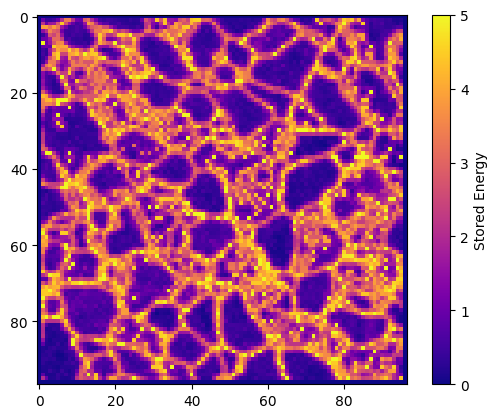

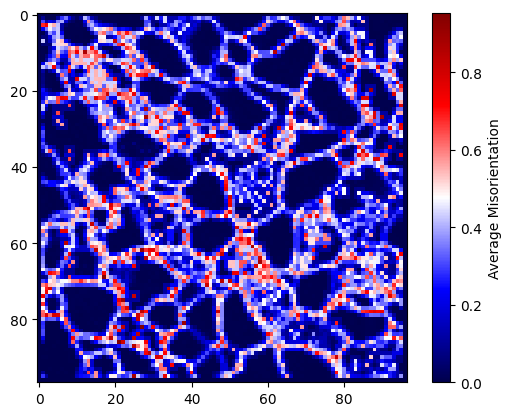

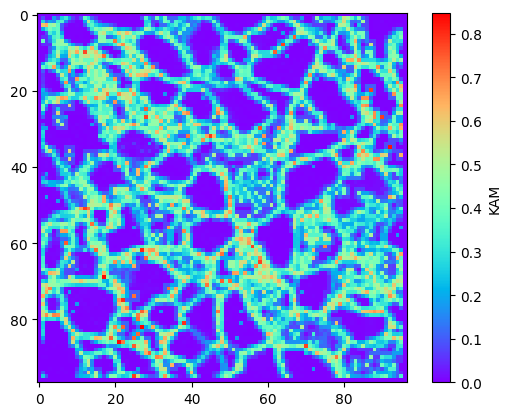

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(stored_energy_values, cmap='plasma')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Stored Energy')

fig, ax = plt.subplots()
im = ax.imshow(average_misorientation, cmap='seismic')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Average Misorientation')


fig, ax = plt.subplots()
im = ax.imshow(kam, cmap='rainbow')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('KAM')

plt.show()


(<Figure size 640x480 with 1 Axes>, <Axes: >)


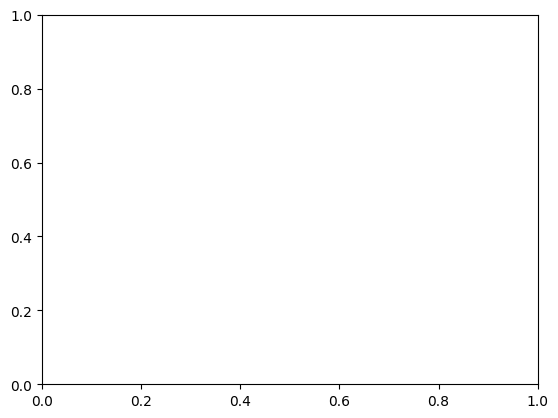

In [ ]:
print((plt.subplots()))